# Binary Classification Model for Springleaf Marketing Response Using Python Take 2
### David Lowe
### March 17, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The Springleaf Marketing Response dataset is a binary classification situation where we are trying to predict one of the two possible outcomes.

INTRODUCTION: Springleaf leverages the direct mail method for connecting with customers who may need a loan. To improve their targeting efforts, Springleaf must be sure they are focusing on the customers who are likely to respond and be good candidates for their services. Using a dataset with a broad set of anonymized features, Springleaf is looking to predict which customers will respond to a direct mail offer.

In iteration Take1, we constructed several traditional machine learning models using the linear, non-linear, and ensemble techniques. We also observed the best ROC-AUC result that we could obtain with each of these models.

In this Take2 iteration, we will construct and tune an XGBoost machine learning model for this dataset. We will observe the best ROC-AUC result that we can obtain with the XGBoost model.

ANALYSIS: In iteration Take1, the baseline performance of the machine learning algorithms achieved an average ROC-AUC of 70.42%. The Random Forest and Gradient Boosting Machine algorithms made the top ROC-AUC metrics after the first round of modeling. After a series of tuning trials, GBM turned in an overall ROC-AUC result of 77.96%. When we apply the tuned GBM algorithm to the test dataset, we obtained a ROC-AUC score of only 62.58%, which was much lower than the score from model training.

In this Take2 iteration, the XGBoost algorithm achieved a baseline ROC-AUC performance of 77.08%. After a series of tuning trials, XGBoost turned in an overall best ROC-AUC result of 78.23%. When we apply the tuned XGBoost algorithm to the test dataset, we obtained a ROC-AUC score of only 62.86%, which was much lower than the score from model training.

CONCLUSION: For this iteration, the XGBoost algorithm achieved a ROC-AUC result with high variance using the training and test datasets. For this dataset, we should consider doing more modeling and tuning with the XGBoost and other algorithms.

Dataset Used: Springleaf Marketing Response Data Set

Dataset ML Model: Binary classification with numerical and categorical attributes

Dataset Reference: https://www.kaggle.com/c/springleaf-marketing-response/data

One potential source of performance benchmark: https://www.kaggle.com/c/springleaf-marketing-response/leaderboard

The project aims to touch on the following areas:

* Document a predictive modeling problem end-to-end.
* Explore data cleaning and transformation options
* Explore non-ensemble and ensemble algorithms for baseline model performance
* Explore algorithm tuning techniques for improving model performance

Any predictive modeling machine learning project genrally can be broken down into about six major tasks:

1. Prepare Environment
2. Summarize Data
3. Prepare Data
4. Model and Evaluate Algorithms
5. Improve Accuracy or Results
6. Finalize Model and Present Results

## Section 1 - Prepare Environment

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Mar 11 14:09:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


### 1.a) Load libraries and modules

In [0]:
# Set the random seed number for reproducible results
seedNum = 888

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
import sys
import shutil
import urllib.request
import zipfile
import smtplib
import re
from datetime import datetime
from email.message import EmailMessage
from pandas.plotting import scatter_matrix
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import RUSBoostClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from xgboost import XGBClassifier

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported fro

### 1.b) Set up the controlling parameters and functions

In [0]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set the flag for splitting the dataset
splitDataset = True
splitPercentage = 0.15

# Set the number of folds for cross validation
n_folds = 5

# Set various default modeling parameters
# scoring = 'accuracy'
scoring = 'roc_auc'

# Set various Pandas options
pd.set_option('display.max_rows', 9999)

In [0]:
# Set up the email notification function
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if sender==None or receiver==None or gateway==None or smtpuser==None or password==None:
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Python Binary Classification Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [0]:
if (notifyStatus): email_notify("Library and Data Loading has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [8]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-springleaf-marketing-response/train.csv'
Xy_original = pd.read_csv(dataset_path, sep=',', na_values=["NA"," [] ",""], true_values=["true"], false_values=["false"])

# Take a peek at the dataframe after import
Xy_original.head(10)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8,9,10,11,12,43,157,196,214,225,228,229,231,235,238) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ID,VAR_0001,VAR_0002,VAR_0003,VAR_0004,VAR_0005,VAR_0006,VAR_0007,VAR_0008,VAR_0009,VAR_0010,VAR_0011,VAR_0012,VAR_0013,VAR_0014,VAR_0015,VAR_0016,VAR_0017,VAR_0018,VAR_0019,VAR_0020,VAR_0021,VAR_0022,VAR_0023,VAR_0024,VAR_0025,VAR_0026,VAR_0027,VAR_0028,VAR_0029,VAR_0030,VAR_0031,VAR_0032,VAR_0033,VAR_0034,VAR_0035,VAR_0036,VAR_0037,VAR_0038,VAR_0039,...,VAR_1896,VAR_1897,VAR_1898,VAR_1899,VAR_1900,VAR_1901,VAR_1902,VAR_1903,VAR_1904,VAR_1905,VAR_1906,VAR_1907,VAR_1908,VAR_1909,VAR_1910,VAR_1911,VAR_1912,VAR_1913,VAR_1914,VAR_1915,VAR_1916,VAR_1917,VAR_1918,VAR_1919,VAR_1920,VAR_1921,VAR_1922,VAR_1923,VAR_1924,VAR_1925,VAR_1926,VAR_1927,VAR_1928,VAR_1929,VAR_1930,VAR_1931,VAR_1932,VAR_1933,VAR_1934,target
0,2,H,224,0,4300,C,0.0,0.0,False,False,False,False,False,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,997,997,997,147,198,173,0,98,98,98,98,98,98,98,998,999999998,999999998,999999998,999999998,998,998,9998,9998,0,98,999999998,999999998,9998,0,98,98,998,999999998,998,998,9998,9998,IAPS,0
1,4,H,7,53,4448,B,1.0,0.0,False,False,False,False,False,1.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,49,49,3,21,12,2,2,0,2,0,0,0,0,0,6546,6546,6125,76,1,1,9996,111,0,98,999999998,999999998,9998,0,98,98,998,999999998,998,998,9998,9998,IAPS,0
2,5,H,116,3,3464,C,0.0,0.0,False,False,False,False,False,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,997,997,45,46,46,1,0,0,3,0,97,0,97,997,999999997,999999997,999999997,999999997,1,997,9996,113,0,98,999999998,999999998,9998,0,98,98,998,999999998,998,998,9998,9998,IAPS,0
3,7,H,240,300,3200,C,0.0,0.0,False,False,False,False,False,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,120,30,996,996,15,188,106,0,98,98,98,98,98,98,98,998,999999998,999999998,999999998,999999998,998,998,9998,9998,0,98,999999998,999999998,9998,0,98,98,998,999999998,998,998,9998,9998,RCC,0
4,8,R,72,261,2000,N,0.0,0.0,False,False,False,False,False,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,30,1,17,17,76,443,230,0,98,98,98,98,98,98,98,998,999999998,999999998,999999998,999999998,998,998,9998,9998,0,98,999999998,999999998,9998,0,98,98,998,999999998,998,998,9998,9998,BRANCH,1
5,14,R,4,4,4422,C,0.0,0.0,False,False,False,False,False,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,998,998,998,998,9998,9998,9998,0,98,98,98,98,98,98,98,998,999999998,999999998,999999998,999999998,998,998,9998,9998,0,98,999999998,999999998,9998,0,98,98,998,999999998,998,998,9998,9998,IAPS,0
6,16,H,60,132,40000,C,1.0,1.0,False,False,False,False,False,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,1.0,1.0,0.0,0.0,...,1,1,997,997,69,215,139,0,98,98,98,98,98,98,98,998,999999998,999999998,999999998,999999998,998,998,9998,9998,0,98,999999998,999999998,9998,1,0,1,0,999999996,400,400,9996,76,IAPS,1
7,20,R,13,75,3600,B,0.0,0.0,False,False,False,False,False,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,60,60,70,70,14,14,14,0,98,98,98,98,98,98,98,998,999999998,999999998,999999998,999999998,998,998,9998,9998,0,98,999999998,999999998,9998,0,98,98,998,999999998,998,998,9998,9998,IAPS,0
8,21,R,17,16,2296,N,1.0,1.0,False,False,False,False,False,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,400,120,83,83,58,90,80,0,0,0,19,0,0,0,0,0,999999996,33459,999999996,999999996,1,1,9996,35,0,98,999999998,999999998,9998,1,0,97,997,999999997,400,997,9996,90,MOBILE,1
9,22,R,24,72,450,N,0.0,0.0,False,False,False,False,False,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,1.

In [9]:
Xy_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145231 entries, 0 to 145230
Data columns (total 1934 columns):
ID          int64
VAR_0001    object
VAR_0002    int64
VAR_0003    int64
VAR_0004    int64
VAR_0005    object
VAR_0006    float64
VAR_0007    float64
VAR_0008    object
VAR_0009    object
VAR_0010    object
VAR_0011    object
VAR_0012    object
VAR_0013    float64
VAR_0014    float64
VAR_0015    float64
VAR_0016    float64
VAR_0017    float64
VAR_0018    float64
VAR_0019    float64
VAR_0020    float64
VAR_0021    float64
VAR_0022    float64
VAR_0023    float64
VAR_0024    float64
VAR_0025    float64
VAR_0026    float64
VAR_0027    float64
VAR_0028    float64
VAR_0029    float64
VAR_0030    float64
VAR_0031    float64
VAR_0032    float64
VAR_0033    float64
VAR_0034    float64
VAR_0035    float64
VAR_0036    float64
VAR_0037    float64
VAR_0038    float64
VAR_0039    float64
VAR_0040    float64
VAR_0041    float64
VAR_0042    float64
VAR_0043    object
VAR_0044    object
VAR_

In [10]:
null_counts = Xy_original.isnull().sum()
null_counts[null_counts > 0]

VAR_0006        56
VAR_0007        56
VAR_0008        56
VAR_0009        56
VAR_0010        56
VAR_0011        56
VAR_0012        56
VAR_0013        56
VAR_0014        56
VAR_0015        56
VAR_0016        56
VAR_0017        56
VAR_0018        56
VAR_0019        56
VAR_0020        56
VAR_0021        56
VAR_0022        56
VAR_0023        56
VAR_0024        56
VAR_0025        56
VAR_0026        56
VAR_0027        56
VAR_0028        56
VAR_0029        56
VAR_0030        56
VAR_0031        56
VAR_0032        56
VAR_0033        56
VAR_0034        56
VAR_0035        56
VAR_0036        56
VAR_0037        56
VAR_0038        56
VAR_0039        56
VAR_0040        56
VAR_0041        56
VAR_0042        56
VAR_0043        56
VAR_0044        56
VAR_0045        56
VAR_0046        56
VAR_0047        56
VAR_0048        56
VAR_0049        56
VAR_0050        56
VAR_0051        56
VAR_0052        56
VAR_0053        56
VAR_0054        56
VAR_0055        56
VAR_0056        56
VAR_0057        56
VAR_0058    

In [11]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  3511742


### 1.d) Data Cleaning

In [0]:
# Standardize the class column to the name of targetVar if required
Xy_original = Xy_original.rename(columns={'target': 'targetVar'})

In [0]:
# Impute missing values
Xy_original.dropna(subset=['VAR_0008', 'VAR_0090', 'VAR_0242', 'VAR_0200', 'VAR_0350'], inplace=True)

In [0]:
# Dropping features due to too many missing values in the columns
Xy_original.drop(columns=['VAR_0073', 'VAR_0074'], inplace=True)
Xy_original.drop(columns=['VAR_0156', 'VAR_0157', 'VAR_0158', 'VAR_0159'], inplace=True)
Xy_original.drop(columns=['VAR_0166', 'VAR_0167', 'VAR_0168', 'VAR_0169'], inplace=True)
Xy_original.drop(columns=['VAR_0176', 'VAR_0177', 'VAR_0178', 'VAR_0179'], inplace=True)
Xy_original.drop(columns=['VAR_0205', 'VAR_0206', 'VAR_0207', 'VAR_0208', 'VAR_0209'], inplace=True)
Xy_original.drop(columns=['VAR_0210', 'VAR_0211', 'VAR_0212', 'VAR_0213', 'VAR_0214'], inplace=True)
Xy_original.drop(columns=['VAR_0840'], inplace=True)

In [0]:
# Dropping features due to non-predictive nature of the columns
Xy_original.drop(columns=['ID'], inplace=True)
Xy_original.drop(columns=['VAR_0008', 'VAR_0009', 'VAR_0010', 'VAR_0011', 'VAR_0012'], inplace=True)
Xy_original.drop(columns=['VAR_0018', 'VAR_0019', 'VAR_0020', 'VAR_0021', 'VAR_0022'], inplace=True)
Xy_original.drop(columns=['VAR_0023', 'VAR_0024', 'VAR_0025', 'VAR_0026', 'VAR_0027'], inplace=True)
Xy_original.drop(columns=['VAR_0028', 'VAR_0029', 'VAR_0030', 'VAR_0031', 'VAR_0032'], inplace=True)
Xy_original.drop(columns=['VAR_0038', 'VAR_0039', 'VAR_0040', 'VAR_0041', 'VAR_0042'], inplace=True)
Xy_original.drop(columns=['VAR_0043', 'VAR_0044', 'VAR_0075'], inplace=True)
Xy_original.drop(columns=['VAR_0188', 'VAR_0189', 'VAR_0190'], inplace=True)
Xy_original.drop(columns=['VAR_0196', 'VAR_0197', 'VAR_0199'], inplace=True)
Xy_original.drop(columns=['VAR_0200', 'VAR_0202', 'VAR_0203', 'VAR_0204'], inplace=True)
Xy_original.drop(columns=['VAR_0215', 'VAR_0216', 'VAR_0217'], inplace=True)
Xy_original.drop(columns=['VAR_0221', 'VAR_0222', 'VAR_0223'], inplace=True)
Xy_original.drop(columns=['VAR_0229', 'VAR_0239', 'VAR_0246'], inplace=True)
Xy_original.drop(columns=['VAR_0394', 'VAR_0404', 'VAR_0438'], inplace=True)
Xy_original.drop(columns=['VAR_0493'], inplace=True)
Xy_original.drop(columns=['VAR_0527', 'VAR_0528', 'VAR_0530'], inplace=True)
Xy_original.drop(columns=['VAR_0847'], inplace=True)
Xy_original.drop(columns=['VAR_1428'], inplace=True)

In [0]:
# Convert columns from one data type to another
Xy_original['VAR_0001'] = Xy_original['VAR_0001'].astype('category')
Xy_original['VAR_0005'] = Xy_original['VAR_0005'].astype('category')
Xy_original['VAR_0226'] = Xy_original['VAR_0226'].astype('bool')
Xy_original['VAR_0230'] = Xy_original['VAR_0230'].astype('bool')
Xy_original['VAR_0232'] = Xy_original['VAR_0232'].astype('bool')
Xy_original['VAR_0236'] = Xy_original['VAR_0236'].astype('bool')
Xy_original['VAR_0237'] = Xy_original['VAR_0237'].astype('category')
Xy_original['VAR_0274'] = Xy_original['VAR_0274'].astype('category')
Xy_original['VAR_0283'] = Xy_original['VAR_0283'].astype('category')
Xy_original['VAR_0305'] = Xy_original['VAR_0305'].astype('category')
Xy_original['VAR_0325'] = Xy_original['VAR_0325'].astype('category')
Xy_original['VAR_0342'] = Xy_original['VAR_0342'].astype('category')
Xy_original['VAR_0352'] = Xy_original['VAR_0352'].astype('category')
Xy_original['VAR_0353'] = Xy_original['VAR_0353'].astype('category')
Xy_original['VAR_0354'] = Xy_original['VAR_0354'].astype('category')
Xy_original['VAR_0466'] = Xy_original['VAR_0466'].astype('category')
Xy_original['VAR_0467'] = Xy_original['VAR_0467'].astype('category')
Xy_original['VAR_1934'] = Xy_original['VAR_0467'].astype('category')

In [17]:
# Take a peek at the dataframe after cleaning
Xy_original.head(10)

,VAR_0001,VAR_0002,VAR_0003,VAR_0004,VAR_0005,VAR_0006,VAR_0007,VAR_0013,VAR_0014,VAR_0015,VAR_0016,VAR_0017,VAR_0033,VAR_0034,VAR_0035,VAR_0036,VAR_0037,VAR_0045,VAR_0046,VAR_0047,VAR_0048,VAR_0049,VAR_0050,VAR_0051,VAR_0052,VAR_0053,VAR_0054,VAR_0055,VAR_0056,VAR_0057,VAR_0058,VAR_0059,VAR_0060,VAR_0061,VAR_0062,VAR_0063,VAR_0064,VAR_0065,VAR_0066,VAR_0067,...,VAR_1896,VAR_1897,VAR_1898,VAR_1899,VAR_1900,VAR_1901,VAR_1902,VAR_1903,VAR_1904,VAR_1905,VAR_1906,VAR_1907,VAR_1908,VAR_1909,VAR_1910,VAR_1911,VAR_1912,VAR_1913,VAR_1914,VAR_1915,VAR_1916,VAR_1917,VAR_1918,VAR_1919,VAR_1920,VAR_1921,VAR_1922,VAR_1923,VAR_1924,VAR_1925,VAR_1926,VAR_1927,VAR_1928,VAR_1929,VAR_1930,VAR_1931,VAR_1932,VAR_1933,VAR_1934,targetVar
0,H,224,0,4300,C,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,1,997,997,997,147,198,173,0,98,98,98,98,98,98,98,998,999999998,999999998,999999998,999999998,998,998,9998,9998,0,98,999999998,999999998,9998,0,98,98,998,999999998,998,998,9998,9998,-1,0
1,H,7,53,4448,B,1.0,0.0,1.0,0.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,3.0,3.0,3.0,1.0,2.0,2.0,2.0,3.0,3.0,3.0,0.0,0.0,...,1,1,49,49,3,21,12,2,2,0,2,0,0,0,0,0,6546,6546,6125,76,1,1,9996,111,0,98,999999998,999999998,9998,0,98,98,998,999999998,998,998,9998,9998,Discharged,0
2,H,116,3,3464,C,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,1,1,997,997,45,46,46,1,0,0,3,0,97,0,97,997,999999997,999999997,999999997,999999997,1,997,9996,113,0,98,999999998,999999998,9998,0,98,98,998,999999998,998,998,9998,9998,-1,0
3,H,240,300,3200,C,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,120,30,996,996,15,188,106,0,98,98,98,98,98,98,98,998,999999998,999999998,999999998,999999998,998,998,9998,9998,0,98,999999998,999999998,9998,0,98,98,998,999999998,998,998,9998,9998,-1,0
4,R,72,261,2000,N,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,30,1,17,17,76,443,230,0,98,98,98,98,98,98,98,998,999999998,999999998,999999998,999999998,998,998,9998,9998,0,98,999999998,999999998,9998,0,98,98,998,999999998,998,998,9998,9998,-1,1
5,R,4,4,4422,C,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,998,998,998,998,9998,9998,9998,0,98,98,98,98,98,98,98,998,999999998,999999998,999999998,999999998,998,998,9998,9998,0,98,999999998,999999998,9998,0,98,98,998,999999998,998,998,9998,9998,-1,0
6,H,60,132,40000,C,1.0,1.0,1.0,1.0,1.0,2.0,0.0,2.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,3.0,3.0,3.0,1.0,1.0,...,1,1,997,997,69,215,139,0,98,98,98,98,98,98,98,998,999999998,999999998,999999998,999999998,998,998,9998,9998,0,98,999999998,999999998,9998,1,0,1,0,999999996,400,400,9996,76,-1,1
7,R,13,75,3600,B,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,60,60,70,70,14,14,14,0,98,98,98,98,98,98,98,998,999999998,999999998,999999998,999999998,998,998,9998,9998,0,98,999999998,999999998,9998,0,98,98,998,999999998,998,998,9998,9998,-1,0
8,R,17,16,2296,N,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,0.0,0.0,...,400,120,83,83,58,90,80,0,0,0,19,0,0,0,0,0,999999996,33459,999999996,999999996,1,1,9996,35,0,98,999999998,999999998,9998,1,0,97,997,999999997,400,997,9996,90,-1,1
9,R,24,72,450,N,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,1,1,102,102,28,28,28,0,0,0,15,0,0,0,0,0,999999996,40060,999999996,999999996

In [18]:
Xy_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144262 entries, 0 to 145230
Data columns (total 1852 columns):
VAR_0001     category
VAR_0002     int64
VAR_0003     int64
VAR_0004     int64
VAR_0005     category
VAR_0006     float64
VAR_0007     float64
VAR_0013     float64
VAR_0014     float64
VAR_0015     float64
VAR_0016     float64
VAR_0017     float64
VAR_0033     float64
VAR_0034     float64
VAR_0035     float64
VAR_0036     float64
VAR_0037     float64
VAR_0045     float64
VAR_0046     float64
VAR_0047     float64
VAR_0048     float64
VAR_0049     float64
VAR_0050     float64
VAR_0051     float64
VAR_0052     float64
VAR_0053     float64
VAR_0054     float64
VAR_0055     float64
VAR_0056     float64
VAR_0057     float64
VAR_0058     float64
VAR_0059     float64
VAR_0060     float64
VAR_0061     float64
VAR_0062     float64
VAR_0063     float64
VAR_0064     float64
VAR_0065     float64
VAR_0066     float64
VAR_0067     float64
VAR_0068     float64
VAR_0069     float64
VAR_0070 

In [19]:
null_counts = Xy_original.isnull().sum()
null_counts[null_counts > 0]

Series([], dtype: int64)

In [20]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  0


### 1.e) Splitting Data into Attribute-only and Target-only Sets

In [0]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = totCol

In [22]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (144262, 1852) X_original.shape: (144262, 1851) y_original.shape: (144262,)


### 1.f) Set up the parameters for data visualization

In [0]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

In [0]:
if (notifyStatus): email_notify("Library and Data Loading completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 2 - Summarize Data
To gain a better understanding of the data that we have on-hand, we will leverage a number of descriptive statistics and data visualization techniques. The plan is to use the results to consider new questions, review assumptions, and validate hypotheses that we can investigate later with specialized models.

In [0]:
if (notifyStatus): email_notify("Data Summarization and Visualization has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 2.a) Descriptive Statistics

#### 2.a.i) Peek at the attribute columns

In [0]:
# X_original.head(10)

#### 2.a.ii) Dimensions and attribute types

In [0]:
# X_original.info(verbose=True)

#### 2.a.iii) Statistical summary of the attributes

In [0]:
# X_original.describe()

#### 2.a.iv) Summarize the levels of the class attribute

In [29]:
Xy_original.groupby('targetVar').size()

targetVar
0    110718
1     33544
dtype: int64

### 2.b) Data Visualization

In [0]:
# Histograms for each attribute
# X_original.hist(layout=(dispRow,dispCol))
# plt.show()

In [0]:
# Box and Whisker plot for each attribute
# X_original.plot(kind='box', subplots=True, layout=(dispRow,dispCol))
# plt.show()

In [0]:
# Density plot for each attribute
# X_original.plot(kind='density', subplots=True, layout=(dispRow,dispCol))
# plt.show()

In [0]:
# Correlation matrix
# fig = plt.figure(figsize=(16,12))
# ax = fig.add_subplot(111)
# correlations = X_original.corr(method='pearson')
# cax = ax.matshow(correlations, vmin=-1, vmax=1)
# fig.colorbar(cax)
# plt.show()

In [0]:
if (notifyStatus): email_notify("Data Summarization and Visualization completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 3 - Prepare Data
Some dataset may require additional preparation activities that will best exposes the structure of the problem and the relationships between the input attributes and the output variable. Some data-prep tasks might include:

* Cleaning data by removing duplicates, marking missing values and even imputing missing values.
* Feature selection where redundant features may be removed.
* Data transforms where attributes are scaled or redistributed in order to best expose the structure of the problem later to learning algorithms.

In [0]:
if (notifyStatus): email_notify("Data Cleaning and Transformation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Splitting Data into Training and Test Sets

In [36]:
# Perform one-hot-encoding on the categorical attributes
X_original = pd.get_dummies(X_original)
X_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144262 entries, 0 to 145230
Data columns (total 2042 columns):
VAR_0002                 int64
VAR_0003                 int64
VAR_0004                 int64
VAR_0006                 float64
VAR_0007                 float64
VAR_0013                 float64
VAR_0014                 float64
VAR_0015                 float64
VAR_0016                 float64
VAR_0017                 float64
VAR_0033                 float64
VAR_0034                 float64
VAR_0035                 float64
VAR_0036                 float64
VAR_0037                 float64
VAR_0045                 float64
VAR_0046                 float64
VAR_0047                 float64
VAR_0048                 float64
VAR_0049                 float64
VAR_0050                 float64
VAR_0051                 float64
VAR_0052                 float64
VAR_0053                 float64
VAR_0054                 float64
VAR_0055                 float64
VAR_0056                 float64
VA

In [37]:
# Split the data further into training and test datasets
if (splitDataset):
    X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_original, y_original, test_size=splitPercentage, 
                                                                    stratify=y_original, random_state=seedNum)
else:
    X_train_df, y_train_df = X_original, y_original
    X_test_df, y_test_df = X_original, y_original
print("X_train_df.shape: {} y_train_df.shape: {}".format(X_train_df.shape, y_train_df.shape))
print("X_test_df.shape: {} y_test_df.shape: {}".format(X_test_df.shape, y_test_df.shape))

X_train_df.shape: (122622, 2042) y_train_df.shape: (122622,)
X_test_df.shape: (21640, 2042) y_test_df.shape: (21640,)


### 3.b) Feature Scaling and Data Pre-Processing

In [0]:
# Not applicable for this iteration of the project

### 3.c) Training Data Balancing

In [0]:
# Not applicable for this iteration of the project

### 3.d) Feature Selection

In [0]:
# Not applicable for this iteration of the project

### 3.e) Display the Final Datasets for Model-Building

In [41]:
# Finalize the training and testing datasets for the modeling activities
X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()
X_test = X_test_df.to_numpy()
y_test = y_test_df.to_numpy()
print("X_train.shape: {} y_train.shape: {}".format(X_train.shape, y_train.shape))
print("X_test.shape: {} y_test.shape: {}".format(X_test.shape, y_test.shape))

X_train.shape: (122622, 2042) y_train.shape: (122622,)
X_test.shape: (21640, 2042) y_test.shape: (21640,)


In [0]:
if (notifyStatus): email_notify("Data Cleaning and Transformation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 4 - Model and Evaluate Algorithms
After the data-prep, we next work on finding a workable model by evaluating a subset of machine learning algorithms that are good at exploiting the structure of the training. The typical evaluation tasks include:

* Defining test options such as cross validation and the evaluation metric to use.
* Spot checking a suite of linear and nonlinear machine learning algorithms.
* Comparing the estimated accuracy of algorithms.

For this project, we will evaluate one linear, two non-linear and four ensemble algorithms:

Linear Algorithm: Logistic Regression

Non-Linear Algorithm: Decision Trees (CART)

Ensemble Algorithms: Bagged CART, Random Forest, Extra Trees, and Gradient Boosting

The random number seed is reset before each run to ensure that the evaluation of each algorithm is performed using the same data splits. It ensures the results are directly comparable.

### 4.a) Set test options and evaluation metric

In [0]:
# Set up Algorithms Spot-Checking Array
train_models = []
train_results = []
train_model_names = []
train_metrics = []
# train_models.append(('LGR', LogisticRegression(random_state=seedNum)))
# train_models.append(('CART', DecisionTreeClassifier(random_state=seedNum)))
# train_models.append(('BGT', BaggingClassifier(random_state=seedNum, n_jobs=n_jobs)))
# train_models.append(('RNF', RandomForestClassifier(random_state=seedNum, n_jobs=n_jobs)))
# train_models.append(('EXT', ExtraTreesClassifier(random_state=seedNum, n_jobs=n_jobs)))
# train_models.append(('GBM', GradientBoostingClassifier(random_state=seedNum)))
train_models.append(('XGB', XGBClassifier(random_state=seedNum, n_jobs=n_jobs, tree_method='gpu_hist')))

In [44]:
# Generate model in turn
startTimeModule = datetime.now()
for name, model in train_models:
	if (notifyStatus): email_notify("Algorithm "+name+" modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	startTimeModule = datetime.now()
	kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=n_jobs, verbose=1)
	train_results.append(cv_results)
	train_model_names.append(name)
	train_metrics.append(cv_results.mean())
	print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
	print(model)
	print ('Model training time:', (datetime.now() - startTimeModule), '\n')
	if (notifyStatus): email_notify("Algorithm "+name+" modeling completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics ('+scoring+') from all models:',np.mean(train_metrics))
print ('Total training time for all models:',(datetime.now() - startTimeModule))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


XGB: 0.770893 (0.001443)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=888,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)
Model training time: 0:02:57.682428 

Average metrics (roc_auc) from all models: 0.7708926869037656
Total training time for all models: 0:02:57.683303


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.0min finished


### 4.b) Spot-checking baseline algorithms

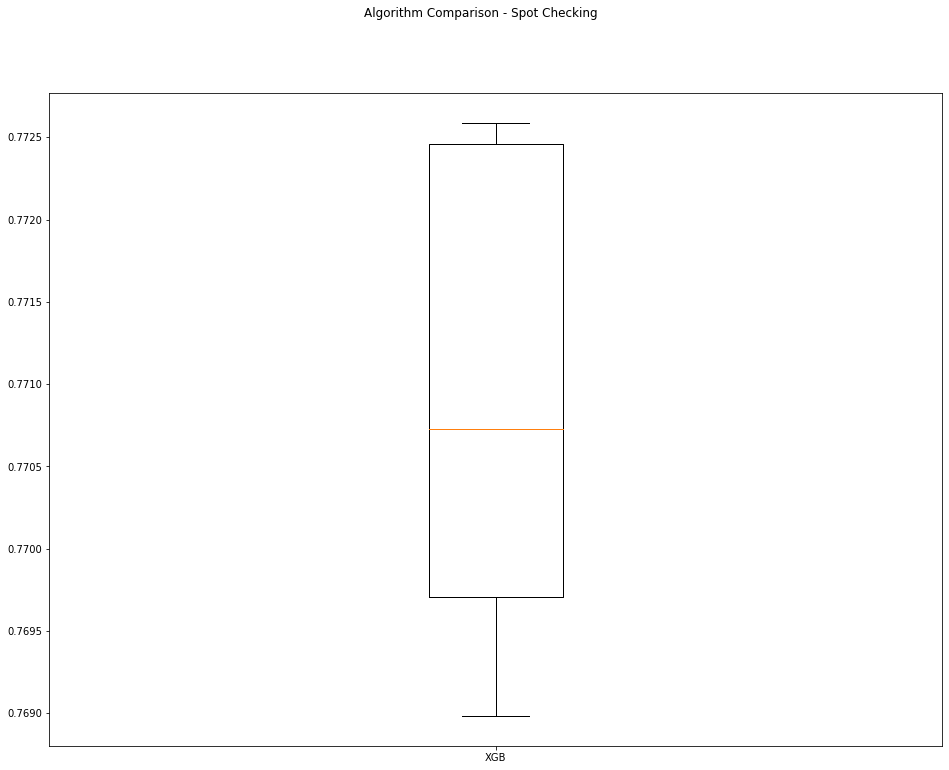

In [45]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
plt.boxplot(train_results)
ax.set_xticklabels(train_model_names)
plt.show()

## Section 5 - Improve Accuracy
After we achieve a short list of machine learning algorithms with good level of accuracy, we can leverage ways to improve the accuracy of the models.

### 5.a) Algorithm Tuning

In [0]:
# Set up the comparison array
tune_results = []
tune_model_names = []

In [47]:
# Tuning algorithm #1 - XGBoost with n_estimators = 500
startTimeModule = datetime.now()
if (notifyStatus): email_notify("Algorithm #1 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model1 = XGBClassifier(n_estimators=500, random_state=seedNum, n_jobs=n_jobs, tree_method='gpu_hist')
tune_model_names.append('XGB1')
paramGrid1 = dict(max_depth=np.array([3, 6, 9]), min_child_weight=np.array([1, 3, 5]))

kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=scoring, cv=kfold, n_jobs=n_jobs, verbose=2)
grid_result1 = grid1.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
if (notifyStatus): email_notify("Algorithm #1 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] max_depth=3, min_child_weight=1 .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................. max_depth=3, min_child_weight=1, total=  43.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   45.1s remaining:    0.0s


[CV] max_depth=3, min_child_weight=1 .................................
[CV] .................. max_depth=3, min_child_weight=1, total=  43.4s
[CV] max_depth=3, min_child_weight=1 .................................
[CV] .................. max_depth=3, min_child_weight=1, total=  43.1s
[CV] max_depth=3, min_child_weight=1 .................................
[CV] .................. max_depth=3, min_child_weight=1, total=  43.2s
[CV] max_depth=3, min_child_weight=1 .................................
[CV] .................. max_depth=3, min_child_weight=1, total=  43.2s
[CV] max_depth=3, min_child_weight=3 .................................
[CV] .................. max_depth=3, min_child_weight=3, total=  42.9s
[CV] max_depth=3, min_child_weight=3 .................................
[CV] .................. max_depth=3, min_child_weight=3, total=  43.4s
[CV] max_depth=3, min_child_weight=3 .................................
[CV] .................. max_depth=3, min_child_weight=3, total=  43.1s
[CV] m

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 42.3min finished


Best: 0.781527 using {'max_depth': 6, 'min_child_weight': 5}
0.780910 (0.002034) with: {'max_depth': 3, 'min_child_weight': 1}
0.781067 (0.002223) with: {'max_depth': 3, 'min_child_weight': 3}
0.780934 (0.002339) with: {'max_depth': 3, 'min_child_weight': 5}
0.780992 (0.002445) with: {'max_depth': 6, 'min_child_weight': 1}
0.781076 (0.002349) with: {'max_depth': 6, 'min_child_weight': 3}
0.781527 (0.001784) with: {'max_depth': 6, 'min_child_weight': 5}
0.777777 (0.003042) with: {'max_depth': 9, 'min_child_weight': 1}
0.778922 (0.002922) with: {'max_depth': 9, 'min_child_weight': 3}
0.779690 (0.002297) with: {'max_depth': 9, 'min_child_weight': 5}
Model training time: 0:43:10.778647


In [48]:
# Tuning algorithm #2 - XGBoost with n_estimators = 1000
startTimeModule = datetime.now()
if (notifyStatus): email_notify("Algorithm #2 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model2 = XGBClassifier(n_estimators=1000, random_state=seedNum, n_jobs=n_jobs, tree_method='gpu_hist')
tune_model_names.append('XGB2')
paramGrid2 = dict(max_depth=np.array([3, 6, 9]), min_child_weight=np.array([1, 3, 5]))

kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
grid2 = GridSearchCV(estimator=tune_model2, param_grid=paramGrid2, scoring=scoring, cv=kfold, n_jobs=n_jobs, verbose=2)
grid_result2 = grid2.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
tune_results.append(grid_result2.cv_results_['mean_test_score'])
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
if (notifyStatus): email_notify("Algorithm #2 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] max_depth=3, min_child_weight=1 .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................. max_depth=3, min_child_weight=1, total=  55.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   57.4s remaining:    0.0s


[CV] max_depth=3, min_child_weight=1 .................................
[CV] .................. max_depth=3, min_child_weight=1, total=  56.3s
[CV] max_depth=3, min_child_weight=1 .................................
[CV] .................. max_depth=3, min_child_weight=1, total=  54.2s
[CV] max_depth=3, min_child_weight=1 .................................
[CV] .................. max_depth=3, min_child_weight=1, total=  53.2s
[CV] max_depth=3, min_child_weight=1 .................................
[CV] .................. max_depth=3, min_child_weight=1, total=  57.1s
[CV] max_depth=3, min_child_weight=3 .................................
[CV] .................. max_depth=3, min_child_weight=3, total=  54.7s
[CV] max_depth=3, min_child_weight=3 .................................
[CV] .................. max_depth=3, min_child_weight=3, total=  56.2s
[CV] max_depth=3, min_child_weight=3 .................................
[CV] .................. max_depth=3, min_child_weight=3, total=  53.5s
[CV] m

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 58.9min finished


Best: 0.782386 using {'max_depth': 3, 'min_child_weight': 3}
0.782132 (0.002498) with: {'max_depth': 3, 'min_child_weight': 1}
0.782386 (0.002475) with: {'max_depth': 3, 'min_child_weight': 3}
0.781929 (0.002729) with: {'max_depth': 3, 'min_child_weight': 5}
0.779452 (0.002825) with: {'max_depth': 6, 'min_child_weight': 1}
0.779524 (0.001781) with: {'max_depth': 6, 'min_child_weight': 3}
0.779695 (0.001456) with: {'max_depth': 6, 'min_child_weight': 5}
0.780603 (0.003162) with: {'max_depth': 9, 'min_child_weight': 1}
0.780371 (0.002902) with: {'max_depth': 9, 'min_child_weight': 3}
0.779787 (0.002402) with: {'max_depth': 9, 'min_child_weight': 5}
Model training time: 0:59:50.805193


In [49]:
# Tuning algorithm #3 - XGBoost with n_estimators = 1500
startTimeModule = datetime.now()
if (notifyStatus): email_notify("Algorithm #3 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model3 = XGBClassifier(n_estimators=1500, random_state=seedNum, n_jobs=n_jobs, tree_method='gpu_hist')
tune_model_names.append('XGB3')
paramGrid3 = dict(max_depth=np.array([3, 6, 9]), min_child_weight=np.array([1, 3, 5]))

kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
grid3 = GridSearchCV(estimator=tune_model3, param_grid=paramGrid3, scoring=scoring, cv=kfold, n_jobs=n_jobs, verbose=2)
grid_result3 = grid3.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result3.best_score_, grid_result3.best_params_))
tune_results.append(grid_result3.cv_results_['mean_test_score'])
means = grid_result3.cv_results_['mean_test_score']
stds = grid_result3.cv_results_['std_test_score']
params = grid_result3.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
if (notifyStatus): email_notify("Algorithm #3 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] max_depth=3, min_child_weight=1 .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................. max_depth=3, min_child_weight=1, total= 1.1min
[CV] max_depth=3, min_child_weight=1 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


[CV] .................. max_depth=3, min_child_weight=1, total= 1.1min
[CV] max_depth=3, min_child_weight=1 .................................
[CV] .................. max_depth=3, min_child_weight=1, total= 1.1min
[CV] max_depth=3, min_child_weight=1 .................................
[CV] .................. max_depth=3, min_child_weight=1, total= 1.1min
[CV] max_depth=3, min_child_weight=1 .................................
[CV] .................. max_depth=3, min_child_weight=1, total= 1.1min
[CV] max_depth=3, min_child_weight=3 .................................
[CV] .................. max_depth=3, min_child_weight=3, total= 1.1min
[CV] max_depth=3, min_child_weight=3 .................................
[CV] .................. max_depth=3, min_child_weight=3, total= 1.2min
[CV] max_depth=3, min_child_weight=3 .................................
[CV] .................. max_depth=3, min_child_weight=3, total= 1.1min
[CV] max_depth=3, min_child_weight=3 .................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 74.4min finished


Best: 0.782261 using {'max_depth': 9, 'min_child_weight': 1}
0.782107 (0.002491) with: {'max_depth': 3, 'min_child_weight': 1}
0.781985 (0.002679) with: {'max_depth': 3, 'min_child_weight': 3}
0.781747 (0.002448) with: {'max_depth': 3, 'min_child_weight': 5}
0.778122 (0.002132) with: {'max_depth': 6, 'min_child_weight': 1}
0.778190 (0.001424) with: {'max_depth': 6, 'min_child_weight': 3}
0.777908 (0.001638) with: {'max_depth': 6, 'min_child_weight': 5}
0.782261 (0.003264) with: {'max_depth': 9, 'min_child_weight': 1}
0.781416 (0.002751) with: {'max_depth': 9, 'min_child_weight': 3}
0.780579 (0.002610) with: {'max_depth': 9, 'min_child_weight': 5}
Model training time: 1:17:04.559925


In [50]:
print(grid_result2.best_params_.items())

dict_items([('max_depth', 3), ('min_child_weight', 3)])


In [0]:
# for key, value in grid_result1.best_params_.items():
#     best_paramKey1 = key
#     best_paramValue1 = value
# print("Captured the best parameter for algorithm #1:", best_paramKey1, '=', best_paramValue1)

### 5.b) Compare Algorithms After Tuning

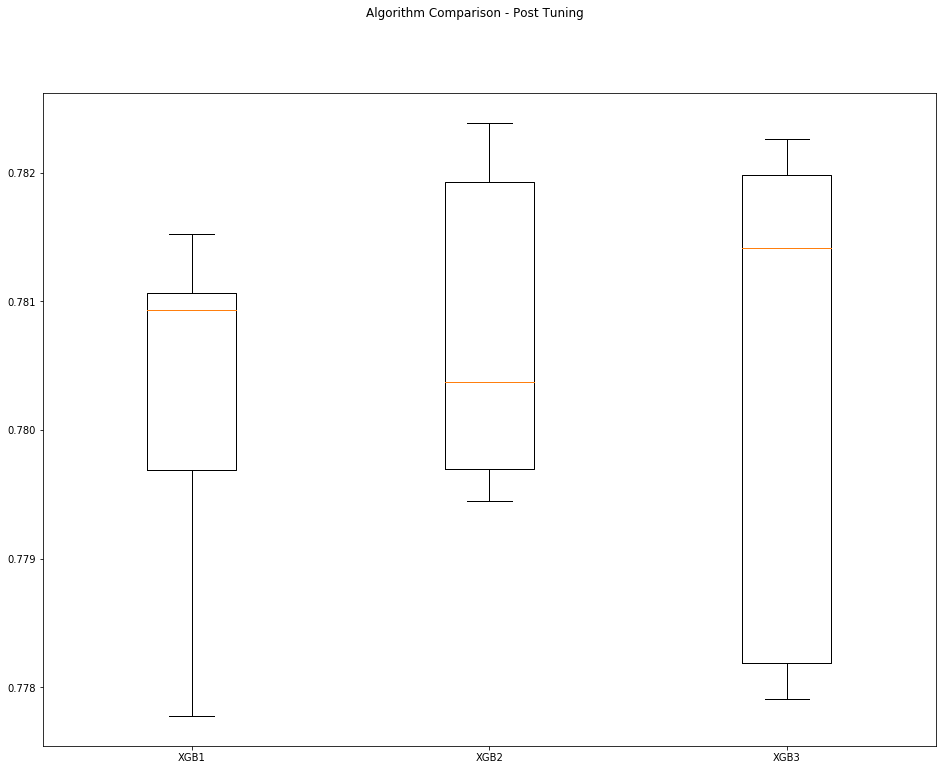

In [52]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(tune_results)
ax.set_xticklabels(tune_model_names)
plt.show()

## Section 6 - Finalize Model
Once we have narrow down to a model that we believe can make accurate predictions on unseen data, we are ready to finalize it. Finalizing a model may involve sub-tasks such as:
* Using an optimal model tuned to make predictions on unseen data.
* Creating a standalone model using the tuned parameters
* Saving an optimal model to file for later use.

In [0]:
if (notifyStatus): email_notify("Model Validation and Final Model Creation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 6.a) Measure predictions from the test dataset

In [54]:
test_model1 = XGBClassifier(n_estimators=1000, max_depth=3, min_child_weight=3, 
                            random_state=seedNum, n_jobs=n_jobs, tree_method='gpu_hist', verbose=2)
test_model1.fit(X_train, y_train)
predictions1 = test_model1.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test, predictions1))
print('ROC/AUC Score:', roc_auc_score(y_test, predictions1))
print(confusion_matrix(y_test, predictions1))
print(classification_report(y_test, predictions1))
print(test_model1)

Accuracy Score: 0.7995378927911275
ROC/AUC Score: 0.6286591440981955
[[15746   862]
 [ 3476  1556]]
              precision    recall  f1-score   support

           0       0.82      0.95      0.88     16608
           1       0.64      0.31      0.42      5032

    accuracy                           0.80     21640
   macro avg       0.73      0.63      0.65     21640
weighted avg       0.78      0.80      0.77     21640

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=3, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=888,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='gpu_hist', verbose=2,
              verbosity=1)


### 6.b) Create a standalone model using all available data

In [0]:
# Combining the training and testing datasets to form the complete dataset that will be used for training the final model
# X_complete = np.vstack((X_train, X_test))
# y_complete = np.concatenate((y_train, y_test))
# print("X_complete.shape: {} y_complete.shape: {}".format(X_complete.shape, y_complete.shape))
# final_model = test_model1.fit(X_complete, y_complete)
# print(final_model)

### 6.c) Save the final model for later use

In [0]:
# modelName = 'FinalModel_BinaryClass.sav'
# dump(final_model, modelName)

In [0]:
if (notifyStatus): email_notify("Model Validation and Final Model Creation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [58]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 4:50:57.506403
